In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 715 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 764s 16s/step - accuracy: 0.6507 - loss: 1.5535 - val_accuracy: 0.3588 - val_loss: 3.6268 - learning_rate: 1.0000e-04
Epoch 2/50
 1/44 ━━━━━━━━━━━━━━━━━━━━ 9:00 13s/step - accuracy: 0.7500 - loss: 1.8227

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7500 - loss: 1.8227 - val_accuracy: 0.0000e+00 - val_loss: 9.6178 - learning_rate: 1.0000e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 699s 15s/step - accuracy: 0.8305 - loss: 0.5749 - val_accuracy: 0.7222 - val_loss: 1.0132 - learning_rate: 1.0000e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8750 - loss: 0.1840 - val_accuracy: 1.0000 - val_loss: 0.2719 - learning_rate: 1.0000e-04
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 669s 14s/step - accuracy: 0.8376 - loss: 0.4187 - val_accuracy: 0.8310 - val_loss: 0.2734 - learning_rate: 1.0000e-04
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8750 - loss: 0.2683 - val_accuracy: 1.0000 - val_loss: 0.0120 - learning_rate: 1.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 664s 14s/step - accuracy: 0.8910 - loss: 0.3064 - val_accuracy: 0.7546 - val_loss: 0.5918 - learning_rate: 1.0000e-04
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8125 - 

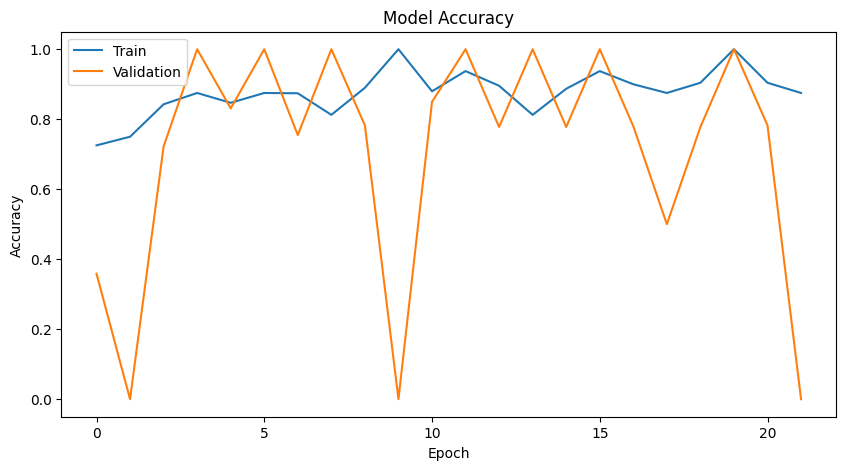

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define image dimensions for preprocessing
height = 300
width = 300

# Define directories for training and validation data
train_dir = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset(500)/Training"
validation_dir = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset(500)/Validation"

# Number of batches for data generators
batch_size = 16

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Data augmentation for validation images
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='binary'
)

# Load EfficientNetB0 model without top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Add custom top layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model with custom top layers
finetune_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
finetune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('best_model_500.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = finetune_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Print the final training and validation accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


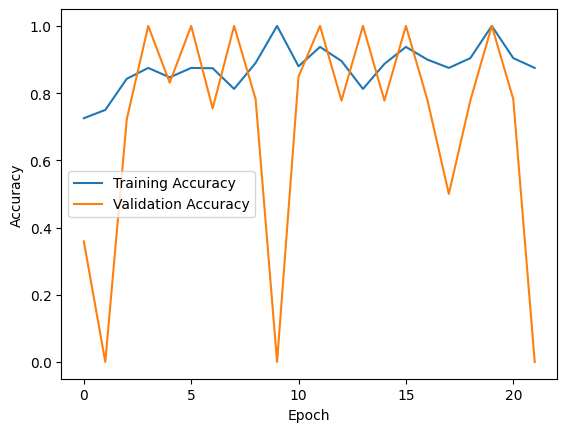

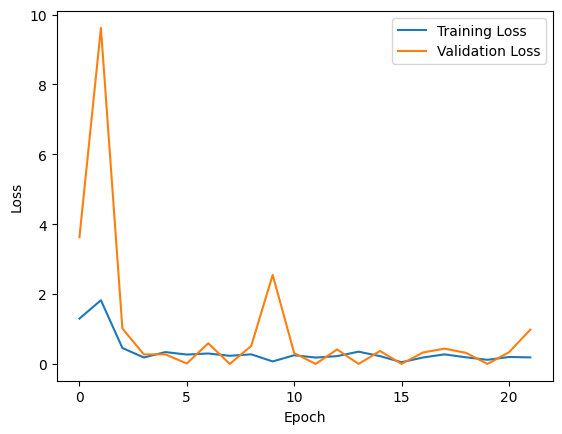

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing the model
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(height, width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Real"
    else:
        return "Fake"




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


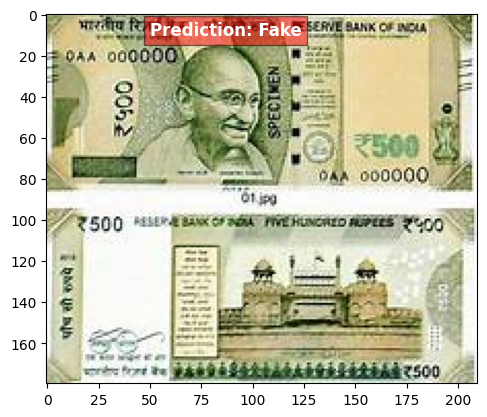

Prediction: Fake


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset(500)/Testing/Fake/fake 2.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


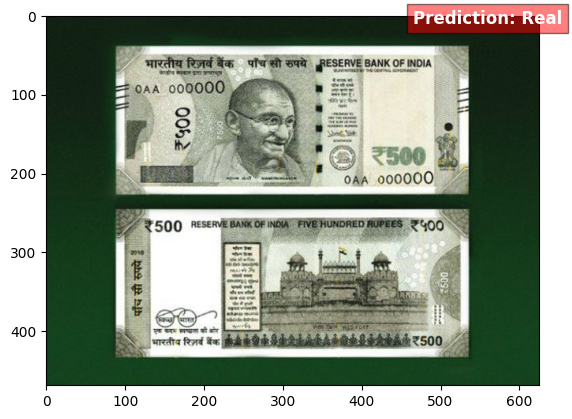

Prediction: Real


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset(500)/Testing/Real/real 3.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


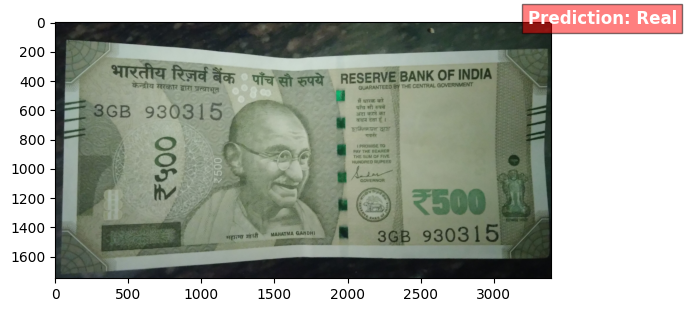

Prediction: Real


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset(500)/Testing/Real/Real 1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


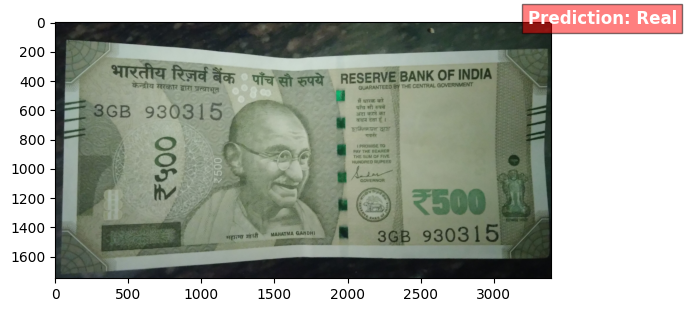

Prediction: Real


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset(500)/Testing/Real/Real 1.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


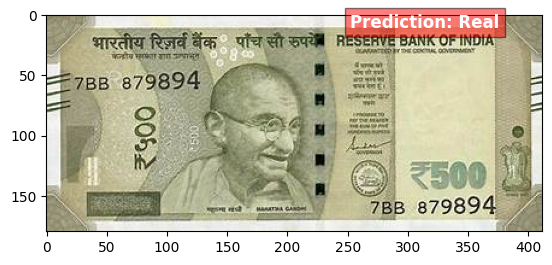

Prediction: Real


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to preprocess and predict the image
def predict_image(model, img_path):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=(height, width))

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to fit the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    # Predict using the model
    prediction = model.predict(img_array)

    # Return the prediction (rounded)
    return "Real" if prediction[0][0] >= 0.5 else "Fake"

# Specify the image path for testing
test_img_path = "/content/drive/MyDrive/MINIPROJECT/500 Rs/Dataset(500)/Testing/Real/Real 3.jpg"

# Load and display the image
img = image.load_img(test_img_path)
plt.imshow(img)

# Predict the image and display the prediction
prediction = predict_image(finetune_model, test_img_path)

# Get image dimensions
img_width, img_height = img.size

# Use plt.text to add the prediction on the image
plt.text(img_width - 160, 10, f'Prediction: {prediction}', fontsize=12, color='white', weight='bold', bbox=dict(facecolor='red', alpha=0.5))

# Show the modified plot
plt.show()

# Print the prediction in the console
print("Prediction:", prediction)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Get overall accuracy on the training set
train_generator.reset()
train_loss, train_accuracy = finetune_model.evaluate(train_generator, steps=train_generator.samples // batch_size, verbose=1)
print(f"Overall Training Accuracy: {train_accuracy * 100:.2f}%")

# Get overall accuracy on the validation set
validation_generator.reset()
val_loss, val_accuracy = finetune_model.evaluate(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
print(f"Overall Validation Accuracy: {val_accuracy * 100:.2f}%")

# Get predictions and true labels for the validation set
validation_generator.reset()
Y_pred = finetune_model.predict(validation_generator, steps=validation_generator.samples // batch_size, verbose=1)
Y_pred_classes = np.where(Y_pred >= 0.5, 1, 0).flatten()  # Convert probabilities to class labels (0 or 1)
Y_true = validation_generator.classes  # True class labels

# Confusion matrix
conf_matrix = confusion_matrix(Y_true[:len(Y_pred_classes)], Y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Overall validation accuracy using sklearn
overall_val_accuracy = accuracy_score(Y_true[:len(Y_pred_classes)], Y_pred_classes)
print(f"Overall Validation Accuracy (from confusion matrix): {overall_val_accuracy * 100:.2f}%")


44/44 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9339 - loss: 0.1322
Overall Training Accuracy: 91.90%
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8696 - loss: 0.2592
Overall Validation Accuracy: 84.95%
27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step
Confusion Matrix:
[[ 14  36]
 [101 281]]
Overall Validation Accuracy (from confusion matrix): 68.29%
